In [4]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.linear_model import LinearRegression
from sklearn.tree import DecisionTreeRegressor
from tqdm.auto import tqdm
import xarray as xr

## Data

In [5]:
df_train = pd.read_csv('data/train.csv', index_col=0)
df_test = pd.read_csv('data/test.csv', index_col=0)

In [6]:
df_train['tt'] = 'train'
df_test['tt'] = 'test'

In [7]:
df = pd.concat([df_train,df_test])

## Feature Creation

In [8]:
df['dateTime'] = pd.to_datetime(df[['year', 'month', 'day', 'hour', 'minute']])

In [9]:
df = df.set_index('dateTime')

In [10]:
df['dayofyear'] = df.index.dayofyear

In [31]:
df_lag1 = df[['surfaceHeight']].resample('D').mean()
df_lag1.index = df_lag1.index + pd.DateOffset(+1)
df_lag1 = df_lag1.rename(columns={'surfaceHeight':'surfaceHeight1D'})

In [56]:
df_1 = df.resample('D').mean().join(df_lag1)

In [58]:
df_1 = df_1[['dayofyear','surfaceHeight1D','surfaceHeight']]

In [59]:
df_train = df_1[:'2020']

In [61]:
df_coef = df_train.groupby('dayofyear').mean()[['surfaceHeight']]
df_train['coef'] = 0.0

for i in tqdm(range(df_coef.shape[0])):
    df_train.loc[df_train['dayofyear']==i,('coef')] = df_coef.reset_index().loc[i,('surfaceHeight')]

/var/folders/mm/04w0hy711n93_t1jwlzttfg00000gp/T/ipykernel_48400/3526873792.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_train['coef'] = 0.0


  0%|          | 0/366 [00:00<?, ?it/s]

<AxesSubplot:xlabel='dayofyear', ylabel='coef'>

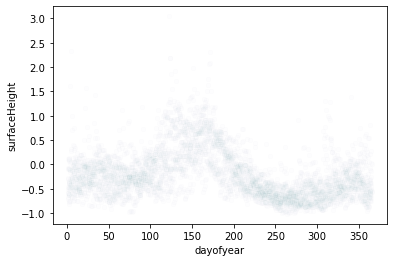

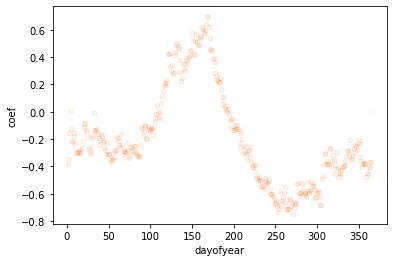

In [62]:
df_train.plot.scatter('dayofyear','surfaceHeight',alpha=0.008)
df_train.plot.scatter('dayofyear','coef',alpha=0.008,color='orange')

In [16]:
df_train.resample('D').mean()

,year,month,day,hour,minute,surfaceHeight,dayofyear,coef
dateTime,,,,,,,,
2010-01-01,2010.0,1.0,1.0,11.111111,29.333333,-0.086667,1.0,-0.316848
2010-01-02,2010.0,1.0,2.0,10.928571,31.464286,0.089643,2.0,-0.331297
2010-01-03,2010.0,1.0,3.0,10.000000,38.227273,-0.412727,3.0,-0.170330
2010-01-04,2010.0,1.0,4.0,14.714286,26.333333,-0.122381,4.0,-0.012135
2010-01-05,2010.0,1.0,5.0,12.057143,25.285714,0.055429,5.0,-0.071157
...,...,...,...,...,...,...,...,...
2020-12-27,2020.0,12.0,27.0,14.428571,29.571429,-0.865714,362.0,-0.218318
2020-12-28,2020.0,12.0,28.0,12.250000,25.875000,-0.640000,363.0,-0.386207
2020-12-29,2020.0,12.0,29.0,11.000000,37.421053,-0.294737,364.0,-0.360926


## Plotting

<AxesSubplot:xlabel='dateTime'>

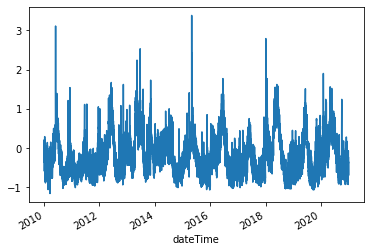

In [63]:
df['surfaceHeight'].plot()

<AxesSubplot:xlabel='dayofyear', ylabel='surfaceHeight'>

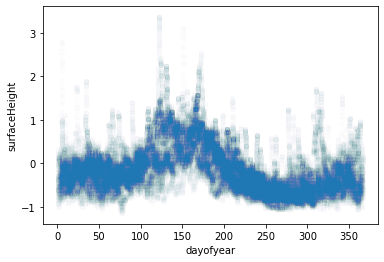

In [64]:
df.plot.scatter('dayofyear','surfaceHeight',alpha=0.008)

## Linear model

In [66]:
model = LinearRegression()

In [67]:
df_train = df_train.dropna()

In [68]:
df_train

,dayofyear,surfaceHeight1D,surfaceHeight,coef
dateTime,,,,
2010-01-02,2.0,-0.086667,0.089643,-0.344623
2010-01-03,3.0,0.089643,-0.412727,-0.154054
2010-01-04,4.0,-0.412727,-0.122381,0.008487
2010-01-05,5.0,-0.122381,0.055429,-0.127631
2010-01-06,6.0,0.055429,-0.132692,-0.213924
...,...,...,...,...
2020-12-27,362.0,-0.654375,-0.865714,-0.402311
2020-12-28,363.0,-0.865714,-0.640000,-0.410817
2020-12-29,364.0,-0.640000,-0.294737,-0.366956


In [83]:
X_train = df_train.drop(columns={'surfaceHeight'})[:'2017']
y_train = df_train['surfaceHeight'][:'2017']

X_test = df_train.drop(columns={'surfaceHeight'})['2017':]
y_test = df_train['surfaceHeight']['2017':]

In [78]:
model.fit(X_train,y_train)

LinearRegression()

In [79]:
y_predict = model.predict(X_test)

<AxesSubplot:xlabel='dateTime'>

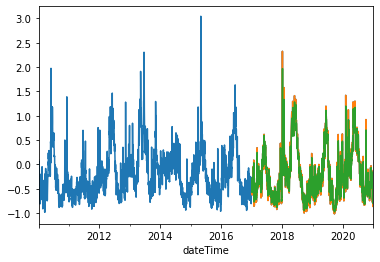

In [80]:
X_test['prediction'] = model.predict(X_test)
X_test['surfaceHeight'] = y_test

df_train['surfaceHeight'].plot()
X_test['surfaceHeight'].plot()
X_test['prediction'].plot()

<AxesSubplot:xlabel='dayofyear', ylabel='prediction'>

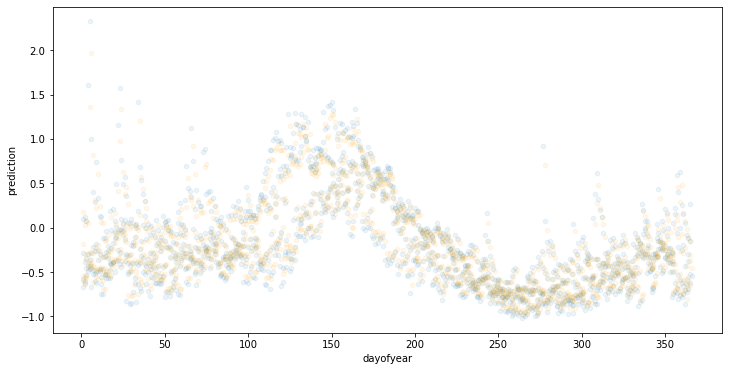

In [82]:
plt.figure(figsize=(12,6))
ax = plt.axes()
X_test.plot.scatter('dayofyear','surfaceHeight',alpha=0.08,ax=ax)
X_test.plot.scatter('dayofyear','prediction',alpha=0.08,ax=ax,color='orange')

## Decision tree

In [21]:
X_train = df_train[['year', 'month', 'day', 'hour', 'minute','coef','dayofyear']].loc[df_train['year']<2017]
y_train = df_train['surfaceHeight'].loc[df_train['year']<2017]

X_test = df_train[['year', 'month', 'day', 'hour', 'minute','coef','dayofyear']].loc[df_train['year']>=2017]
y_test = df_train['surfaceHeight'].loc[df_train['year']>=2017]

In [84]:
model2 = DecisionTreeRegressor()

model2.fit(X_train,y_train)

y_predict2 = model2.predict(X_test)

<AxesSubplot:xlabel='dateTime'>

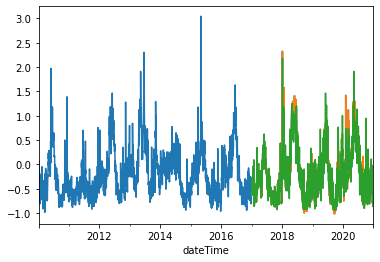

In [85]:
X_test['prediction2'] = model2.predict(X_test)
X_test['surfaceHeight'] = y_test

df_train['surfaceHeight'].plot()
X_test['surfaceHeight'].plot()
X_test['prediction2'].plot()

<Axes: xlabel='dayofyear', ylabel='prediction2'>

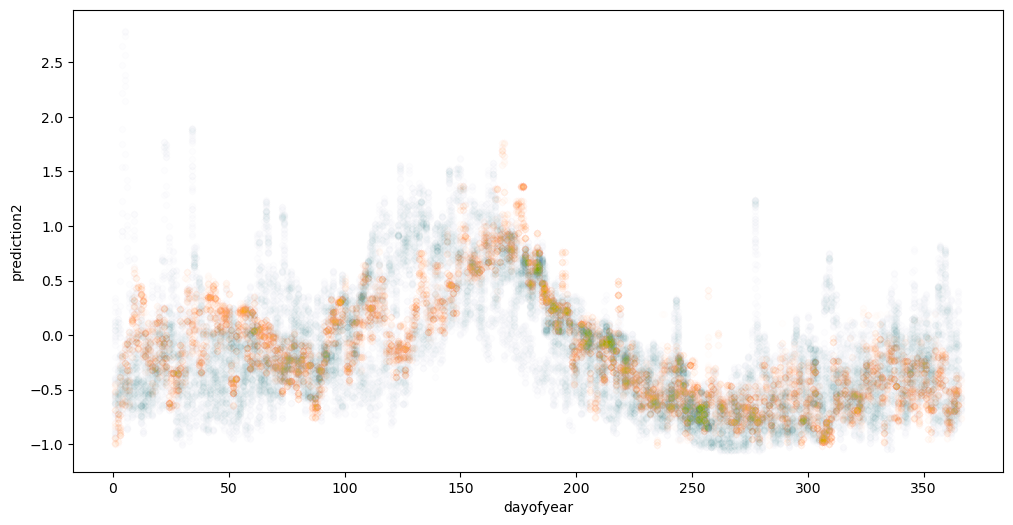

In [24]:
plt.figure(figsize=(12,6))
ax = plt.axes()
X_test.plot.scatter('dayofyear','surfaceHeight',alpha=0.008,ax=ax)
X_test.plot.scatter('dayofyear','prediction2',alpha=0.008,ax=ax,color='orange')

In [25]:
MAE1 = np.mean(np.sqrt(abs(y_predict-y_test)))

In [26]:
MAE2 = np.mean(np.sqrt(abs(y_predict2-y_test)))

In [27]:
print(MAE1,MAE2)

0.5266973605287445 0.5345429970527196


In [89]:
# Get feature importances
feature_importances = model2.feature_importances_

# Now, you can print or visualize feature importances
for feature, importance in zip(X_train.columns, feature_importances):
    print(f"{feature}: {importance}")

dayofyear: 0.03397222287946627
surfaceHeight1D: 0.9194351689693762
coef: 0.046592608151157615


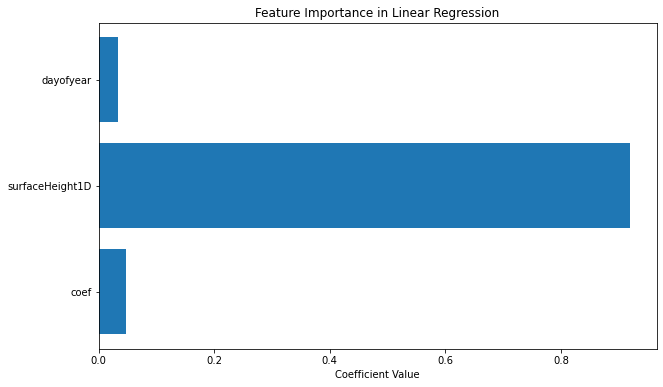

In [91]:
# Get the feature names (assuming X is a pandas DataFrame)
feature_names = X_train.columns

# Create a bar plot
plt.figure(figsize=(10, 6))
plt.barh(range(len(feature_names)), model2.feature_importances_, align='center')
plt.yticks(np.arange(len(feature_names)), feature_names)
plt.xlabel('Coefficient Value')
plt.title('Feature Importance in Linear Regression')
plt.gca().invert_yaxis()  # Invert the y-axis for better visualization
plt.show()

## Model XGboost

In [28]:
# I'll leave this up to you